# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** I Gusti Arya Aditya Dharma
- **Email:** mc179d5y0615@student.devacademy.id
- **ID Dicoding:** MC179D5Y0615

In [ ]:
pip install tensorflowjs


## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving Pizza-or-Not.zip to Pizza-or-Not.zip
Buffered data was truncated after reaching the output size limit.

In [10]:
!unzip Pizza-or-Not.zip -d Pizza-or-Not

Archive:  Pizza-or-Not.zip
  inflating: Pizza-or-Not/pizza_not_pizza/food101_subset.py  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1005746.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1009225.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1012312.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1018802.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1020735.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1027142.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/102839.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1043233.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1045400.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/104773.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1050956.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1054362.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/1062097.jpg  
  inflating: Pizza-or-Not/pizza_not_pizza/not_pizza/106

In [12]:
import os

extract_path = "Pizza-or-Not"

print("Isi folder setelah ekstraksi:")
for item in os.listdir(extract_path):
    print("-", item)


Isi folder setelah ekstraksi:
- pizza_not_pizza


In [14]:
# 1. EKSTRAK FILE ZIP

# Pastikan nama file ZIP sesuai dengan yang diupload
zip_filename = "Pizza-or-Not.zip"
extract_path = "pizza_dataset"

# Ekstrak file ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset berhasil diekstrak ke:", extract_path)

✅ Dataset berhasil diekstrak ke: pizza_dataset


### Data Preprocessing

#### Split Dataset

In [15]:
# Cek isi folder kategori
actual_data_path = os.path.join(extract_path, "pizza_not_pizza")

for category in ["pizza", "not_pizza"]:
    folder = os.path.join(actual_data_path, category)
    if os.path.exists(folder):
        print(f"✅ {category}: {len(os.listdir(folder))} gambar")
    else:
        print(f"❌ Folder '{category}' tidak ditemukan!")

✅ pizza: 983 gambar
✅ not_pizza: 983 gambar


In [16]:
# Path ke folder dataset hasil ekstraksi
source_dir = os.path.join("pizza_dataset", "pizza_not_pizza")

# Path ke folder baru untuk dataset gabungan
combined_dir = "combined_dataset"

# Buat direktori gabungan
os.makedirs(combined_dir, exist_ok=True)

# Daftar kategori (subfolder)
categories = ["pizza", "not_pizza"]

# Salin semua gambar dari masing-masing kategori ke folder gabungan
for category in categories:
    src_category_dir = os.path.join(source_dir, category)
    dst_category_dir = os.path.join(combined_dir, category)
    os.makedirs(dst_category_dir, exist_ok=True)

    for filename in os.listdir(src_category_dir):
        src_file = os.path.join(src_category_dir, filename)
        dst_file = os.path.join(dst_category_dir, filename)

        if os.path.isfile(src_file):
            shutil.copy2(src_file, dst_file)

print("Data berhasil digabung ke folder:", combined_dir)


Data berhasil digabung ke folder: combined_dataset


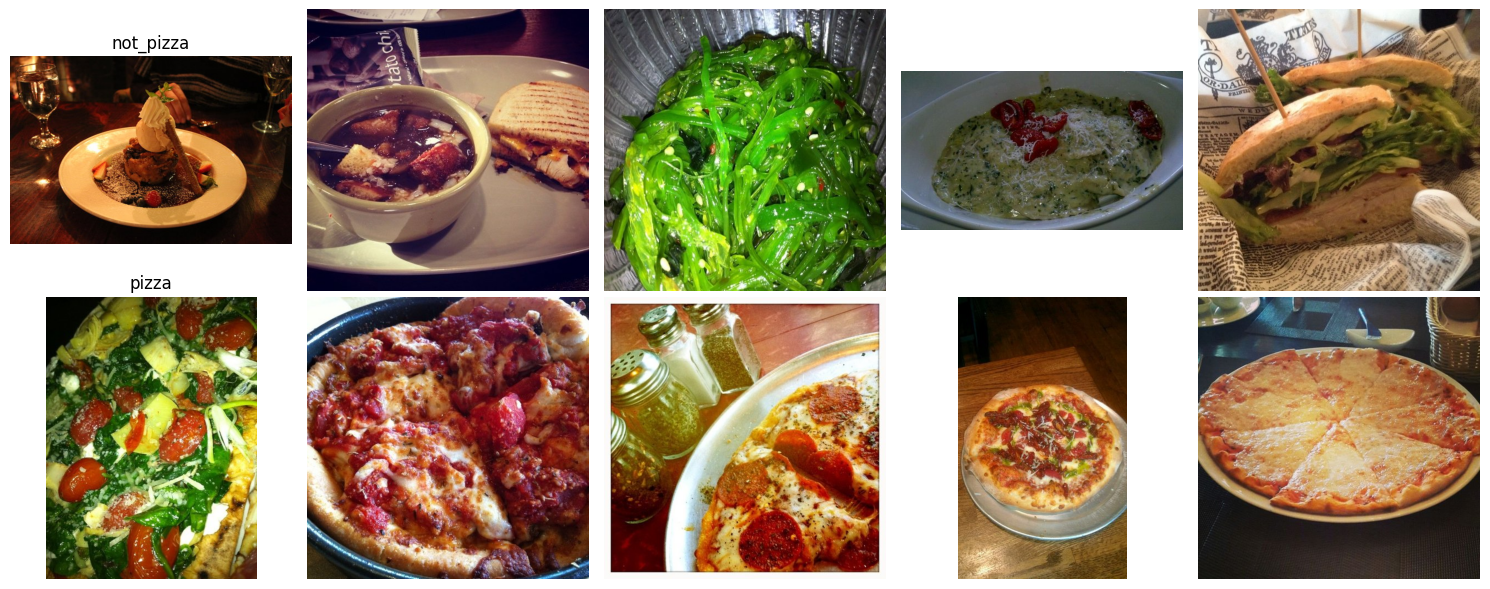

In [17]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas
pizza_image = {}
path_sub = "combined_dataset"

# Baca semua gambar per kelas
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):  # pastikan hanya folder
        pizza_image[class_name] = os.listdir(class_path)

# Jumlah gambar yang ingin ditampilkan per kelas
num_images = 5

# Buat subplots
num_classes = len(pizza_image)
fig, axs = plt.subplots(num_classes, num_images, figsize=(num_images * 3, num_classes * 3))

# Jika hanya 1 kelas, axs akan jadi 1D, jadi kita ubah jadi 2D agar konsisten
if num_classes == 1:
    axs = np.expand_dims(axs, axis=0)

# Tampilkan gambar secara acak untuk setiap kelas
for i, (class_name, images) in enumerate(pizza_image.items()):
    sample_images = np.random.choice(images, min(num_images, len(images)), replace=False)

    for j in range(num_images):
        ax = axs[i, j]

        if j < len(sample_images):
            img_path = os.path.join(path_sub, class_name, sample_images[j])
            img = Image.open(img_path).convert("RGB")
            ax.imshow(img)
        else:
            ax.axis("off")  # kosongkan slot jika gambar kurang dari 5

        ax.set_title(class_name if j == 0 else "")
        ax.axis("off")

fig.tight_layout()
plt.show()


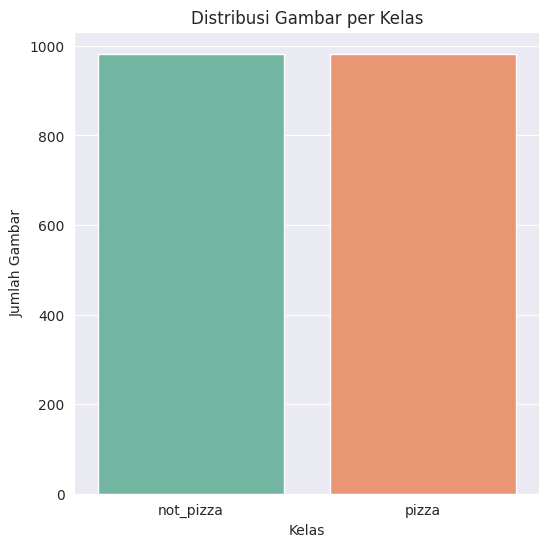

In [18]:
# Path ke direktori dataset gabungan
dataset_path = "combined_dataset/"

# List penyimpanan file
file_name = []
labels = []
full_path = []

# Loop untuk mengambil nama file, path lengkap, dan label
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter opsional
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))  # Nama folder sebagai label
            file_name.append(name)

# Buat DataFrame dari data yang dikumpulkan
distribution_data = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi gambar berdasarkan label
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_data, x='labels', palette='Set2')
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.show()

In [19]:
# Set seed untuk konsistensi
random.seed(42)
np.random.seed(42)

# Resize standar
def resize_image(img):
    return tf.image.resize(img, (224, 224))

# 1. Rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = resize_image(img)
    return tf.image.rot90(img, k=random.randint(1, 3))

# 2. Rotasi searah jarum jam (flip horizontal setelah rotasi)
def clockwise_rotation(img):
    img = resize_image(img)
    rotated = tf.image.rot90(img, k=random.randint(1, 3))
    return tf.image.flip_left_right(rotated)

# 3. Flip vertikal
def flip_up_down(img):
    img = resize_image(img)
    return tf.image.flip_up_down(img)

# 4. Tambah kecerahan
def add_brightness(img):
    img = resize_image(img)
    return tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.4))

# 5. Blur menggunakan average pooling
def blur_image(img):
    img = resize_image(img)
    img = tf.expand_dims(img, 0)
    img = tf.nn.avg_pool2d(img, ksize=3, strides=1, padding='SAME')
    return tf.squeeze(img, axis=0)

# 6. Shear menggunakan ImageDataGenerator
def sheared(img):
    img = resize_image(img)
    img = tf.clip_by_value(img, 0.0, 1.0)
    img = img * 255.0
    img = tf.cast(img, tf.uint8)
    img = img_to_array(Image.fromarray(np.uint8(img.numpy())))
    img = img.reshape((1,) + img.shape)
    datagen = ImageDataGenerator(shear_range=20)
    augmented = next(datagen.flow(img, batch_size=1))[0]
    return tf.convert_to_tensor(augmented / 255.0, dtype=tf.float32)

# 7. Warp shift
def warp_shift(img):
    img = resize_image(img)
    img = tf.clip_by_value(img, 0.0, 1.0)
    img = img * 255.0
    img = tf.cast(img, tf.uint8)
    img = img_to_array(Image.fromarray(np.uint8(img.numpy())))
    img = img.reshape((1,) + img.shape)
    datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
    augmented = next(datagen.flow(img, batch_size=1))[0]
    return tf.convert_to_tensor(augmented / 255.0, dtype=tf.float32)

# Semua fungsi augmentasi
augmentations = [
    anticlockwise_rotation,
    clockwise_rotation,
    flip_up_down,
    add_brightness,
    blur_image,
    sheared,
    warp_shift
]

# Path sumber dan target
source_dir = "combined_dataset"
target_dir = "augmented_dataset"

# Loop per kelas dan gambar
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Buat folder target untuk kelas ini
    output_class_dir = os.path.join(target_dir, class_name)
    os.makedirs(output_class_dir, exist_ok=True)

    for img_name in os.listdir(class_path):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = tf.convert_to_tensor(np.array(img), dtype=tf.float32) / 255.0

            # Simpan gambar asli yang sudah diresize
            base = resize_image(img_tensor)
            base_save = Image.fromarray(np.uint8(base.numpy() * 255))
            base_save.save(os.path.join(output_class_dir, f"original_{img_name}"))

            # Terapkan setiap augmentasi dan simpan hasilnya
            for i, aug_fn in enumerate(augmentations):
                aug_img = aug_fn(img_tensor)
                aug_img = tf.clip_by_value(aug_img, 0.0, 1.0)
                aug_img = Image.fromarray(np.uint8(aug_img.numpy() * 255))
                save_name = f"aug{i+1}_{img_name}"
                aug_img.save(os.path.join(output_class_dir, save_name))

        except Exception as e:
            print(f"⚠️ Gagal memproses {img_path}: {e}")

print("✅ Augmentasi selesai. Data disimpan di:", target_dir)


✅ Augmentasi selesai. Data disimpan di: augmented_dataset


In [20]:
# Pastikan semua fungsi transformasi dan resize_image sudah didefinisikan

transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "pizza_dataset/pizza_not_pizza/pizza"
augmented_path = "pizza_dataset/pizza_not_pizza/pizza_augmented"
os.makedirs(augmented_path, exist_ok=True)

images = [os.path.join(images_path, im) for im in os.listdir(images_path)
          if im.lower().endswith(('.png', '.jpg', '.jpeg'))]

images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image_path = random.choice(images)
    try:
        original_image = io.imread(image_path)

        if original_image.ndim == 2:
            original_image = np.stack((original_image,) * 3, axis=-1)
        elif original_image.shape[2] == 4:
            original_image = original_image[:, :, :3]

        img_tensor = tf.convert_to_tensor(original_image / 255.0, dtype=tf.float32)
        img_tensor = resize_image(img_tensor)

        transformation_count = random.randint(1, 3)
        for _ in range(transformation_count):
            key = random.choice(list(transformations.keys()))
            img_tensor = transformations[key](img_tensor)

        img_tensor = tf.clip_by_value(img_tensor, 0.0, 1.0)
        transformed_image = (img_tensor.numpy() * 255).astype(np.uint8)
        save_path = os.path.join(augmented_path, f"augmented_image_{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
        i += 1

    except Exception as e:
        print(f"⚠️ Gagal memproses gambar {image_path}: {e}")


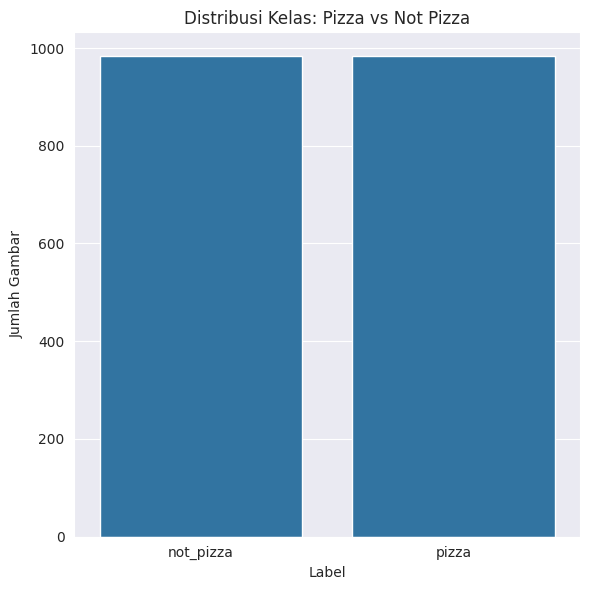

In [21]:
# Path ke folder dataset pizza
pizza_path = "combined_dataset"

# Label valid (hanya yang asli)
valid_labels = ['pizza', 'not_pizza']

# List untuk menyimpan informasi gambar
file_name = []
labels = []
full_path = []

# Loop melalui folder dan ambil hanya gambar dari label yang valid
for path, subdirs, files in os.walk(pizza_path):
    current_label = os.path.basename(path)
    if current_label not in valid_labels:
        continue  # Lewati folder yang bukan 'pizza' atau 'not_pizza'

    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path.append(os.path.join(path, name))
            labels.append(current_label)
            file_name.append(name)

# Buat DataFrame dari data
distribution_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Visualisasi distribusi kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x='labels')
plt.title("Distribusi Kelas: Pizza vs Not Pizza")
plt.xlabel("Label")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()


In [22]:
# Path dataset pizza or not pizza
mypath = 'combined_dataset'

# Daftar label yang valid
valid_labels = ['pizza', 'not_pizza']

# List penampung data
file_name = []
labels = []
full_path = []

# Looping untuk mengambil gambar dan label yang valid
for path, subdirs, files in os.walk(mypath):
    current_label = os.path.basename(path)
    if current_label not in valid_labels:
        continue  # Skip folder yang bukan label asli (contoh: 'pizza_augmented')

    for name in files:
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            full_path.append(os.path.join(path, name))
            labels.append(current_label)
            file_name.append(name)

# Masukkan ke DataFrame agar rapi
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Tampilkan jumlah data per label
print(df.groupby(['labels']).size())


labels
not_pizza    983
pizza        983
dtype: int64


In [23]:
base_dir = "pizza_dataset/pizza_not_pizza"

# Buat dataframe dari file gambar
data = []
for label in ["pizza", "not_pizza"]:
    folder = os.path.join(base_dir, label)
    for file in os.listdir(folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            data.append({'path': os.path.join(folder, file), 'labels': label})

df = pd.DataFrame(data)

# Split menjadi fitur dan label
X = df['path']
y = df['labels']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=300)

# Gabung kembali ke DataFrame
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Print ukuran dataset
print('Train size:', len(df_tr))
print('Test size:', len(df_te))


Train size: 1572
Test size: 394


In [24]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   not_pizza    197
       pizza        197
train  not_pizza    786
       pizza        786
dtype: int64 


                                                   path     labels    set
171   pizza_dataset/pizza_not_pizza/not_pizza/223190...  not_pizza  train
1487    pizza_dataset/pizza_not_pizza/pizza/1098197.jpg      pizza  train
1963  pizza_dataset/pizza_not_pizza/not_pizza/191982...  not_pizza   test
1735     pizza_dataset/pizza_not_pizza/pizza/259449.jpg      pizza   test
1812  pizza_dataset/pizza_not_pizza/not_pizza/348209...  not_pizza   test


In [25]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "combined_dataset"

# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [26]:
from tqdm import tqdm
# Loop dengan tqdm yang benar
for index, row in tqdm(df_all.iterrows(), total=len(df_all)):
    # Deteksi file path
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

    # Buat direktori tujuan jika belum ada
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Tentukan tujuan file
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file dari sumber ke tujuan jika belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)


100%|██████████| 1966/1966 [00:02<00:00, 849.75it/s]


In [27]:
# Path dataset
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_pizza = os.path.join(TRAIN_DIR, 'pizza')
train_not_pizza = os.path.join(TRAIN_DIR, 'not_pizza')
test_pizza = os.path.join(TEST_DIR, 'pizza')
test_not_pizza = os.path.join(TEST_DIR, 'not_pizza')

# Cetak jumlah file
print("Total 'pizza' (train):", len(os.listdir(train_pizza)))
print("Total 'not_pizza' (train):", len(os.listdir(train_not_pizza)))
print("Total 'pizza' (test):", len(os.listdir(test_pizza)))
print("Total 'not_pizza' (test):", len(os.listdir(test_not_pizza)))

# Train & validation generator (dengan augmentasi)
datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Test generator (tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Train
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Test
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    color_mode='rgb',
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


Total 'pizza' (train): 786
Total 'not_pizza' (train): 786
Total 'pizza' (test): 197
Total 'not_pizza' (test): 197
Found 1258 images belonging to 2 classes.
Found 314 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


## Modelling

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

# Bersihkan session sebelumnya
tf.keras.backend.clear_session()

# CNN model
model = Sequential()

# 1st Conv Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Kompilasi model
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,747,201 (41.00 MB)

 Trainable params: 10,746,689 (41.00 MB)

 Non-trainable params: 512 (2.00 KB)

In [30]:
from sklearn.utils import class_weight

# Class weights
train_labels = train_generator.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: weights[i] for i in range(len(weights))}
print("Class weights:", class_weights)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3)


Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}


In [31]:
history_1 = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 195s 5s/step - accuracy: 0.5825 - loss: 5.3574 - val_accuracy: 0.5860 - val_loss: 0.7896 - learning_rate: 0.0010
Epoch 2/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - accuracy: 0.6082 - loss: 2.5729 - val_accuracy: 0.4682 - val_loss: 0.7702 - learning_rate: 0.0010
Epoch 3/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.5944 - loss: 1.7326 - val_accuracy: 0.5096 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 4/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.6480 - loss: 1.1621 - val_accuracy: 0.5605 - val_loss: 0.6653 - learning_rate: 0.0010
Epoch 5/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - accuracy: 0.6542 - loss: 0.8643 - val_accuracy: 0.5955 - val_loss: 0.6494 - learning_rate: 0.0010
Epoch 6/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.6408 - loss: 0.9435 - val_accuracy: 0.5000 - val_loss: 0.7399 - learning_rate: 0.0010
Epoch 7/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 198s 5s/step - accuracy: 0.6747 - loss: 0.7842 - val_acc

## Evaluasi dan Visualisasi

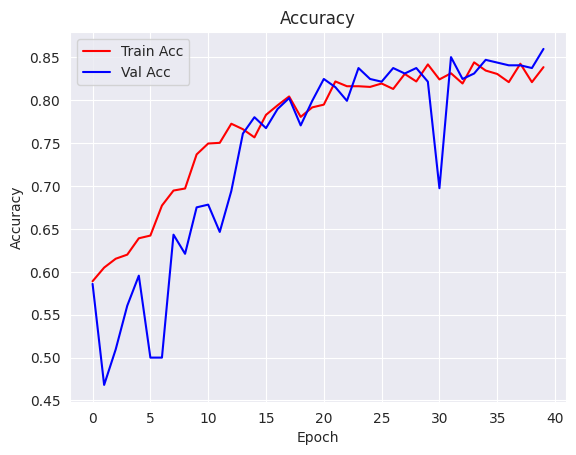

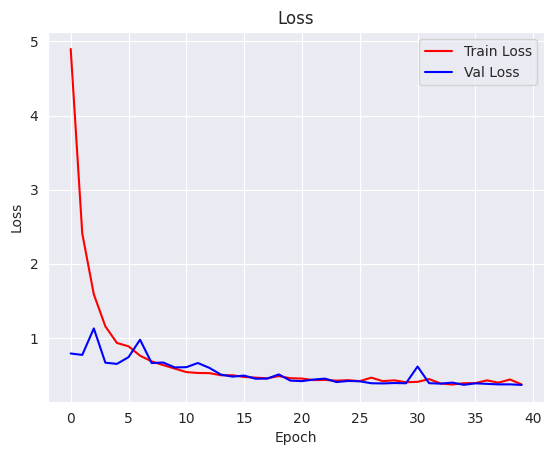

In [32]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Konversi Model

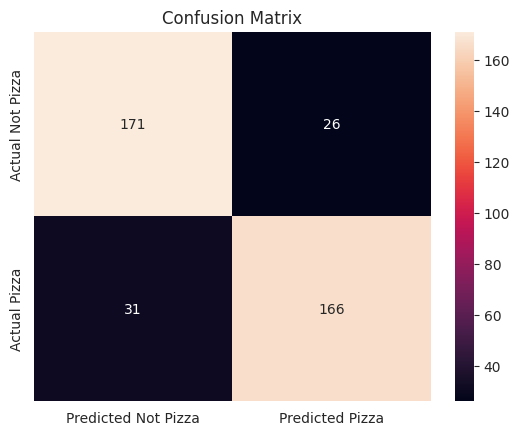

              precision    recall  f1-score   support

   Not Pizza     0.8465    0.8680    0.8571       197
       Pizza     0.8646    0.8426    0.8535       197

    accuracy                         0.8553       394
   macro avg     0.8556    0.8553    0.8553       394
weighted avg     0.8556    0.8553    0.8553       394



In [33]:
test_generator.reset()
preds = model.predict(test_generator, verbose=0)
preds = (preds > 0.5).astype(int)

cm = pd.DataFrame(confusion_matrix(test_generator.classes, preds, labels=[0, 1]),
                  index=["Actual Not Pizza", "Actual Pizza"],
                  columns=["Predicted Not Pizza", "Predicted Pizza"])

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(test_generator.classes, preds, target_names=['Not Pizza', 'Pizza'], digits=4))


## Inference (Optional)

In [34]:
# Kriteria 7: Simpan Model

# Simpan ke SavedModel format
# Export to SavedModel format (for TFLite or TF Serving)
model.export("saved_model/pizza_model")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/pizza_model")
tflite_model = converter.convert()
with open("saved_model/pizza_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at 'saved_model/pizza_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134719956608656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956602896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956607696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956610576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956608848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956610960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956605008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956606928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956612688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134719956610768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1347199

In [35]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/pizza_model tfjs_model/

2025-05-09 18:20:51.243703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746814851.287942   45053 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746814851.300610   45053 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-09 18:21:02.020362: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1746814862.389803   45053 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [36]:
!pip freeze > requirements.txt

In [37]:
!cat requirements.txt

absl-py==1.4.0
accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.6
ale-py==0.11.0
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.28.0.37.27
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.1.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.2
bokeh==3.7.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
commun